# Integration of scATAC data with scPoli

In this notebook we demonstrate an example workflow of scATAC data integration. We integrate data obtained from the .[NeurIPS 2021 multimodal single cell data integration](https://openproblems.bio/competitions/neurips_2021/). The data can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122).

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scarches.models.scpoli import scPoli

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
 captum (see https://github.com/pytorch/captum).


In [2]:
sc.settings.set_figure_params(dpi=100, frameon=False)
sc.set_figure_params(dpi=100)
sc.set_figure_params(figsize=(3, 3))
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (3, 3)

In [3]:
adata = sc.read('../datasets/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')
# remove those that appear in fewer than 5% of the cells
sc.pp.filter_genes(adata, min_cells=int(adata.shape[0] * 0.05))

We select the ATAC features, specify the covariates we want to use as condition and cell type annotation and transform the data from reads to fragments.

In [4]:
adata = adata[:, adata.var['feature_types']=='ATAC']
adata.X = adata.X.todense()
adata.X = adata.X.astype('float32')

In [5]:
condition_key = 'Samplename'
cell_type_key = 'cell_type'

In [7]:
from scarches.models.scpoli._utils import reads_to_fragments
adata_fragments = reads_to_fragments(adata, copy=True)

We instantiate a model with a Poisson likelihood and train it.

In [10]:
scpoli_model = scPoli(
    adata=adata_fragments,
    condition_keys=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[100],
    latent_dim=25,
    embedding_dims=5,
    recon_loss='poisson',
)
scpoli_model.train(
    n_epochs=100,
    pretraining_epochs=95,
    use_early_stopping=False,
    alpha_epoch_anneal=1000,
    eta=0.5,
)

Embedding dictionary:
 	Num conditions: [13]
 	Embedding dim: [5]
Encoder Architecture:
	Input Layer in, out and cond: 16134 100 5
	Mean/Var Layer in/out: 100 25
Decoder Architecture:
	First Layer in, out and cond:  25 100 5
	Output Layer in/out:  100 16134 

Initializing dataloaders
Starting training
 |████████████████████| 100.0%  - val_loss: 21214.68 - val_cvae_loss: 21208.48 - val_prototype_loss:    6.20 - val_labeled_loss:   12.40


## Plotting cell embeddings

In [11]:
#get latent representation of reference data
scpoli_model.model.eval()
data_latent = scpoli_model.get_latent(
    adata_fragments,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = adata_fragments.obs.copy()
sc.pp.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


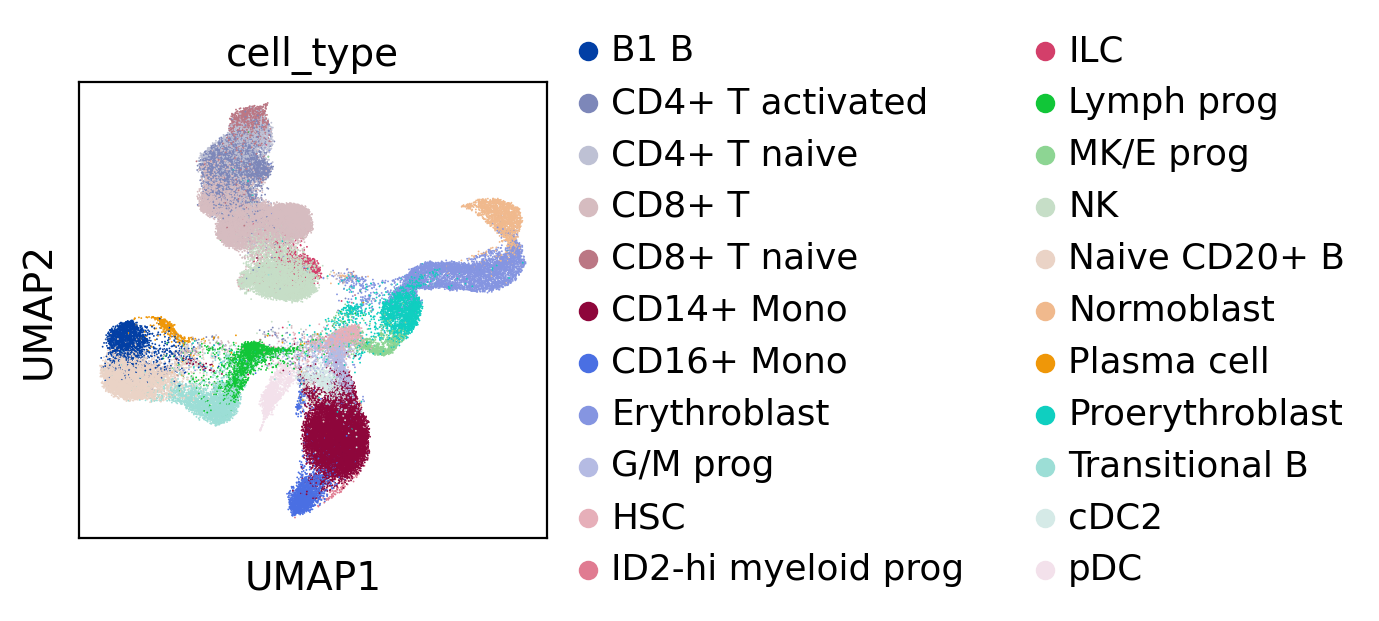

In [12]:
sc.pl.umap(adata_latent, color='cell_type')

In [23]:
adata_emb = scpoli_model.get_conditional_embeddings()
adata_emb.obs = adata.obs.groupby('Samplename').first().reindex(adata_emb.obs.index)

## Plotting sample embeddings

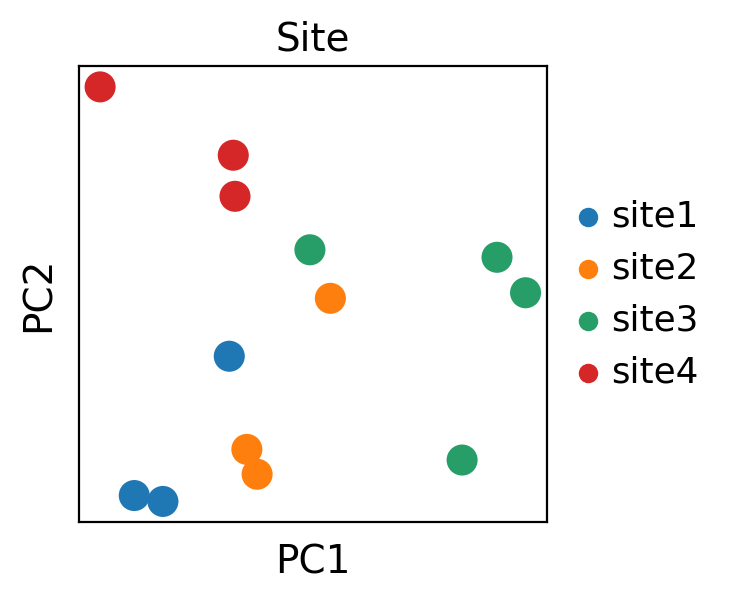

In [24]:
sc.pp.pca(adata_emb)
sc.pl.pca(adata_emb, color='Site', size=500)